* Create a new notebook to see effect of data augmentation a baseline model (`TrainBaseModelAugmentation.ipynb`):
    * Add data augmentation.
        * Select at least 3 augmentations that make sense for your datasets (see [Keras Image Augmentation Layers](https://keras.io/api/layers/preprocessing_layers/image_augmentation/)).
        * Visualize the data augmentation to make sure it's working as expected.
    * Train the same model now with data augmentation.
    * Save the new model.   
    * Test if data augmentation is helping:
        * Create a new notebook (`CompareAugmentation.ipynb`)
        * Load the 2 models and compare the ROC curves with and without augmentation.
* Train the three different transfer learning models (`Train-XXXX.ipynb`):
    * Select 2 additional models from [Keras Built-in Vision Models](https://keras.io/api/applications/).

In [ ]:
data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]


def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

In [ ]:
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf_data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
val_ds = val_ds.prefetch(tf_data.AUTOTUNE)

In [ ]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        units = 1
    else:
        units = num_classes

    x = layers.Dropout(0.25)(x)
    # We specify activation=None so as to return logits
    outputs = layers.Dense(units, activation=None)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
#keras.utils.plot_model(model, show_shapes=True)

In [ ]:
epochs = 8

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.legacy.Adam(3e-4),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy(name="acc")],
)

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/8


2024-04-12 08:06:09.168049: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - 11s 612ms/step - loss: 0.6728 - acc: 0.6358 - val_loss: 0.6935 - val_acc: 0.5000
Epoch 2/8
17/17 [==============================] - 10s 590ms/step - loss: 0.5770 - acc: 0.6975 - val_loss: 0.6935 - val_acc: 0.5000
Epoch 3/8
17/17 [==============================] - 10s 581ms/step - loss: 0.5646 - acc: 0.6790 - val_loss: 0.6935 - val_acc: 0.5000
Epoch 4/8
17/17 [==============================] - 10s 580ms/step - loss: 0.5229 - acc: 0.7346 - val_loss: 0.6936 - val_acc: 0.5000
Epoch 5/8
17/17 [==============================] - 10s 574ms/step - loss: 0.5344 - acc: 0.7222 - val_loss: 0.6937 - val_acc: 0.5000
Epoch 6/8
17/17 [==============================] - 10s 574ms/step - loss: 0.5175 - acc: 0.7469 - val_loss: 0.6936 - val_acc: 0.5000
Epoch 7/8
17/17 [==============================] - 10s 584ms/step - loss: 0.4513 - acc: 0.7469 - val_loss: 0.6939 - val_acc: 0.5000
Epoch 8/8
17/17 [==============================] - 10s 573ms/step - loss: 0.4454 - acc

As you can see, the model doesn't perform very well on this small dataset. It also takes a very long time to go through the data on this laptop without a GPU.

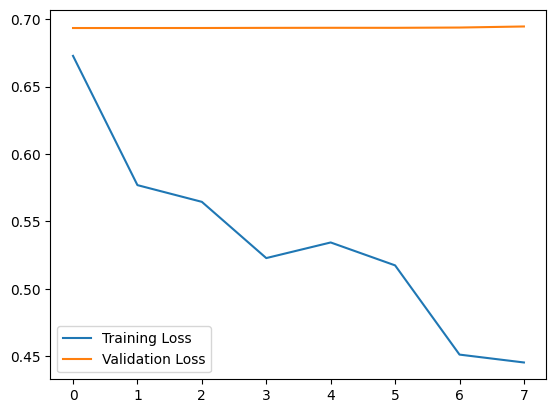

In [ ]:
plt.plot(range(len(history.history["loss"])),history.history["loss"],label="Training Loss")
plt.plot(range(len(history.history["val_loss"])),history.history["val_loss"],label="Validation Loss")
plt.legend()

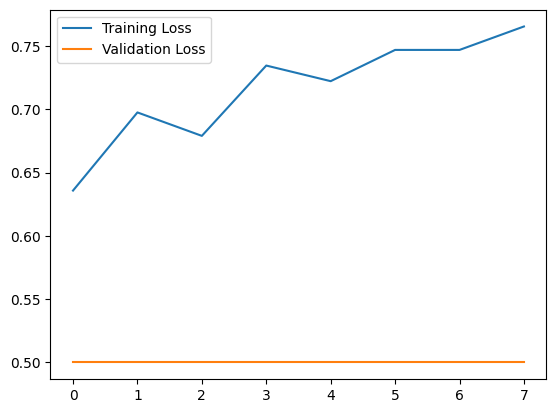

In [ ]:
plt.plot(range(len(history.history["acc"])),history.history["acc"],label="Training Loss")
plt.plot(range(len(history.history["val_acc"])),history.history["val_acc"],label="Validation Loss")
plt.legend()

In [ ]:
# Specify the file path where you want to save the model
model_path = '/users/sashi/Downloads/AugmentedModel'

# Save the model
model.save(model_path)

print("Augmented Model saved successfully")